In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt

In [257]:
df = pd.read_csv('dataset.csv')

### Знакомство с данными

In [258]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


Проверим, есть ли дисбаланс классов таргетной переменной

In [259]:
df["is_promoted"].value_counts()

is_promoted
0    50140
1     4668
Name: count, dtype: int64

In [260]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


Посмотрим на некоторые признаки и попробуем понять наличие зависимостей и влияния на таргет

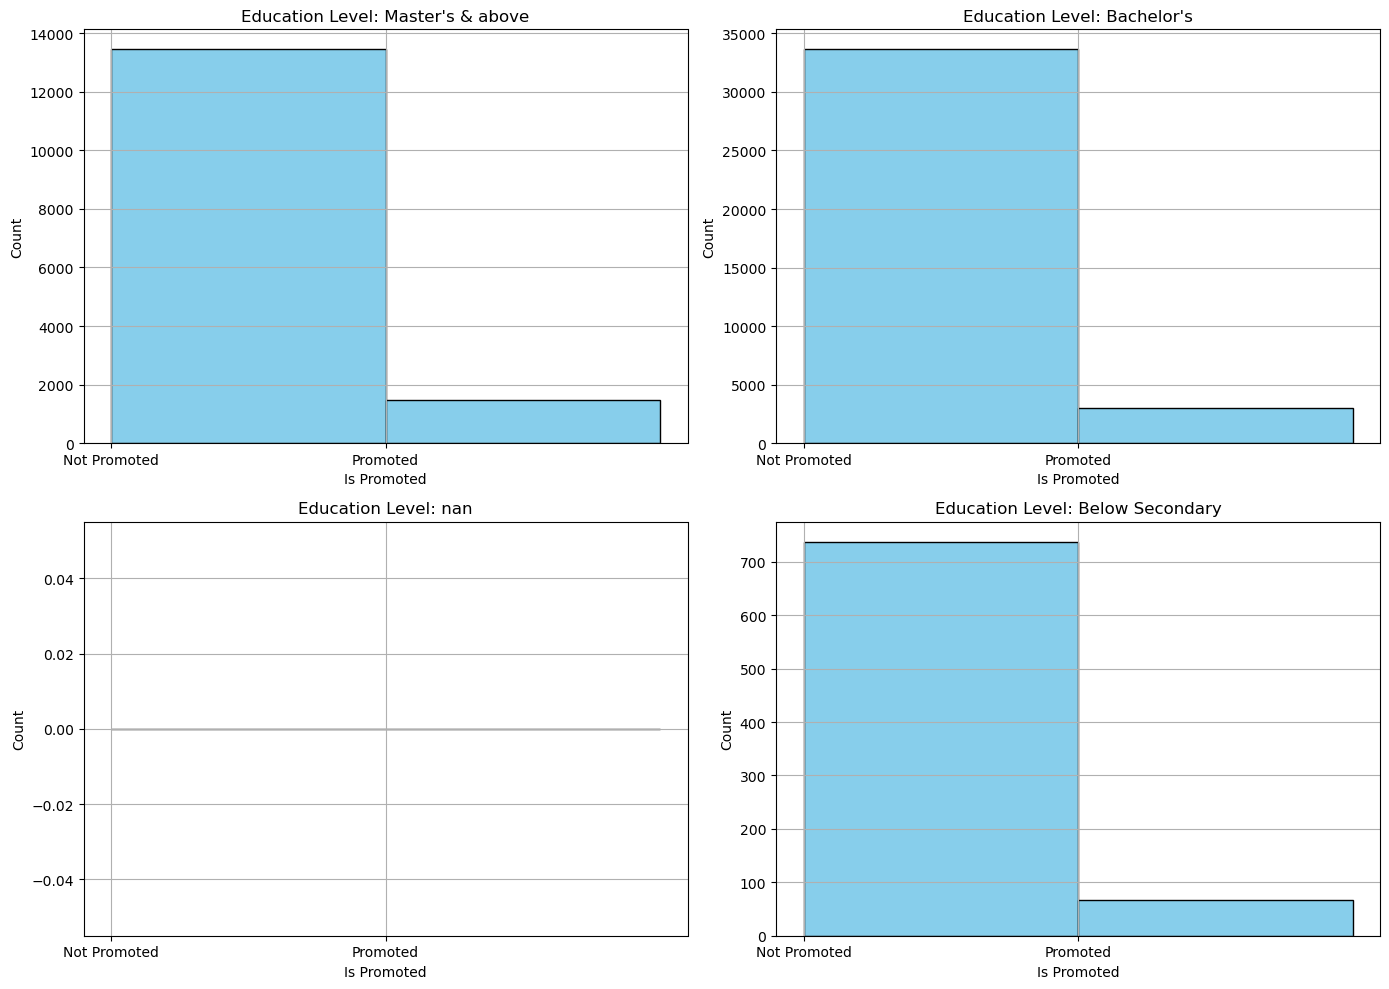

In [262]:
unique_educations = df['education'].unique()

plt.figure(figsize=(14, 10))

for i, education_level in enumerate(unique_educations):
    plt.subplot(2, 2, i + 1)
    counts = df[df['education'] == education_level]['is_promoted'].value_counts(normalize=True) * 100
    df[df['education'] == education_level]['is_promoted'].hist(color='skyblue', bins=[0, 1, 2], edgecolor='black')
    plt.title(f'Education Level: {education_level}')
    plt.xlabel('Is Promoted')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Not Promoted', 'Promoted'])



plt.tight_layout()
plt.show()

Визуально кажется, что образование слабо влияет на соотношение is_promoted

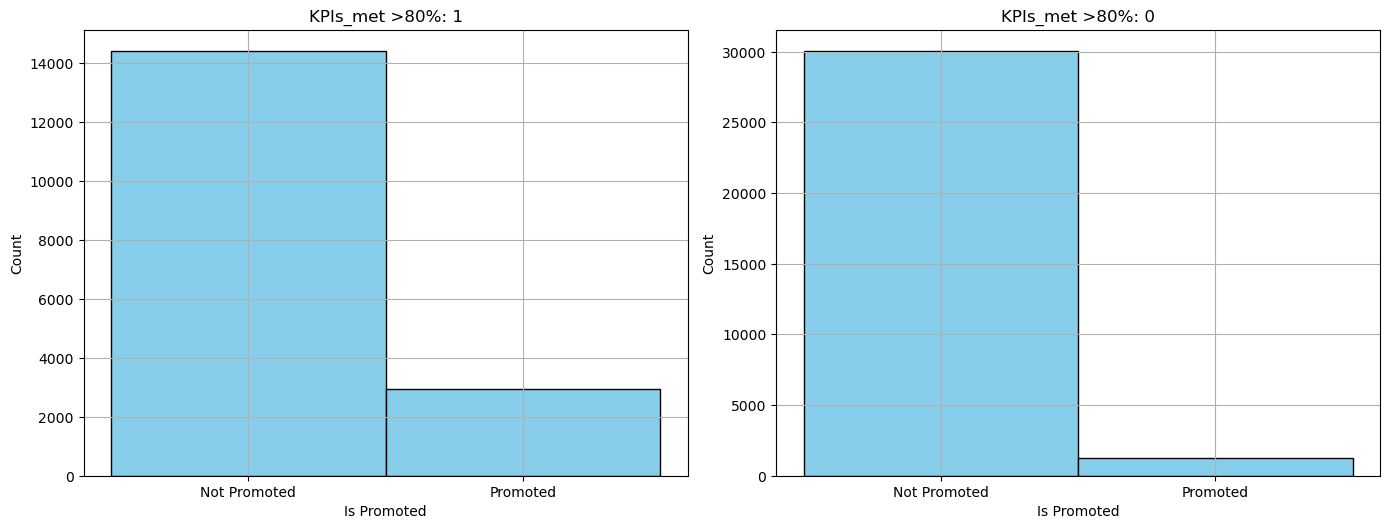

In [283]:
kpi = df['KPIs_met >80%'].unique()

plt.figure(figsize=(14, 10))

for i, kpi_pass in enumerate(kpi):
    plt.subplot(2, 2, i + 1)
    counts = df[df['KPIs_met >80%'] == education_level]['is_promoted'].value_counts(normalize=True) * 100
    df[df['KPIs_met >80%'] == kpi_pass]['is_promoted'].hist(color='skyblue', bins=[0, 1, 2], edgecolor='black')
    plt.title(f'KPIs_met >80%: {kpi_pass}')
    plt.xlabel('Is Promoted')
    plt.ylabel('Count')
    plt.xticks([0.5, 1.5], ['Not Promoted', 'Promoted'])



plt.tight_layout()
plt.show()

Из этих графиков кажется, что значение KPIs_met >80% имеет больше влияние на шанс быть промоутированным

Посмотрим теперь на влияние avg_training_score и length_of_service на таргет

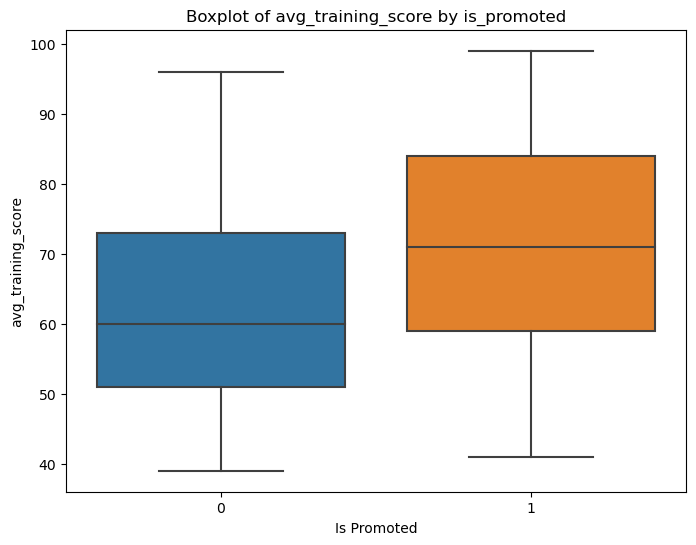

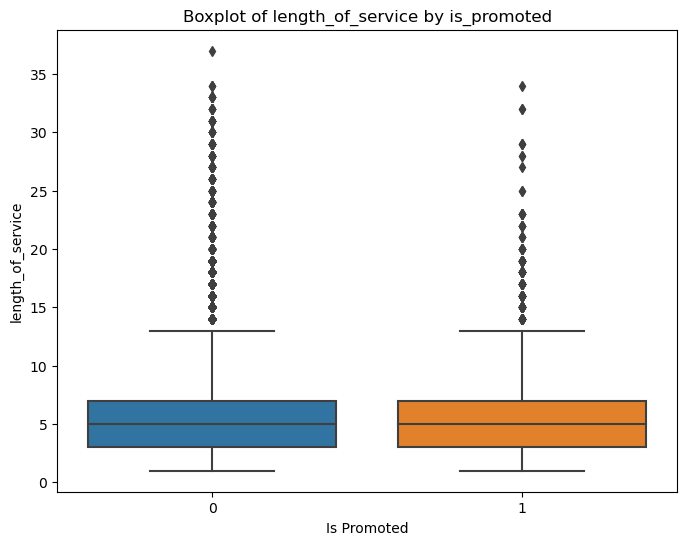

In [264]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_promoted', y='avg_training_score', data=df)
plt.title('Boxplot of avg_training_score by is_promoted')
plt.xlabel('Is Promoted')
plt.ylabel('avg_training_score')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='is_promoted', y='length_of_service', data=df)
plt.title('Boxplot of length_of_service by is_promoted')
plt.xlabel('Is Promoted')
plt.ylabel('length_of_service')
plt.show()

Кажется, что avg_training_score является хорошим признаком

#### Проверим на наличие пропущенных значений

In [265]:
missing_values = df.isnull().sum()

categories_with_missing = missing_values[missing_values > 0]
print("\nКатегории с пропущенными значениями:\n")
print(categories_with_missing)


Категории с пропущенными значениями:

education               2409
previous_year_rating    4124
dtype: int64


Посмотрим на спектр принимаемых значений для признаков education и previous_year_rating

In [266]:
print(df["education"].value_counts())
print(f'\n{df["previous_year_rating"].value_counts()}')

education
Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: count, dtype: int64

previous_year_rating
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: count, dtype: int64


Заполним пропуски случайными значениями (мы хотим построить базовую модель, более сложные манипуляции с пропусками можно будет проводить на последующих этапах улучшения модели)

#### UPD

Как я убедился в дальнейшем, простое удаление строк с с пропусками дает несколько более высокое качество

In [267]:
df.dropna(inplace=True)

# unique_values_education = df['education'].dropna().unique()
# unique_values_previous_year_rating = df['previous_year_rating'].dropna().unique()

# df['education'].fillna(pd.Series(np.random.choice(unique_values_education, size=len(df.index))), inplace=True)
# df['previous_year_rating'].fillna(pd.Series(np.random.choice(unique_values_previous_year_rating, size=len(df.index))), inplace=True)

Убедимся, что в данных больше не осталось пропусков

In [268]:
missing_values = df.isnull().sum()

categories_with_missing = missing_values[missing_values > 0]
print("\nКатегории с пропущенными значениями:\n")
print(categories_with_missing)


Категории с пропущенными значениями:

Series([], dtype: int64)


### Раздели выборку на обучающую и тестовую

Будем использовать стратификацию из-за наличия дисбаланса классов.

Убедимся затем, что действительно и в трейне, и в тесте схожие доли!

Кодирование (через таргет) категориальных признаков будем проводить после разбиения на train и test, чтобы избежать утечки данных

In [269]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["is_promoted"]
)

In [270]:
train_shares = df_train["is_promoted"].value_counts() / df_train.shape[0]
test_shares = df_test["is_promoted"].value_counts() / df_test.shape[0]

to_compare = pd.concat((train_shares, test_shares), axis=1)
to_compare.columns = ['Доля в трейне', 'Доля в тесте']
to_compare['Абсолютная разница'] = (to_compare["Доля в трейне"] - \
                                    to_compare["Доля в тесте"]).abs()

to_compare

,Доля в трейне,Доля в тесте,Абсолютная разница
is_promoted,,,
0,0.913019,0.91307,0.000051
1,0.086981,0.08693,0.000051


Для категориального признака region проведем кодирование при помощи таргетной переменной c небольшим шумом

In [271]:
from category_encoders import TargetEncoder

target_encoder = TargetEncoder(cols=['region'])

df_train['region_encoded'] = target_encoder.fit_transform(df_train['region'], df_train['is_promoted'])

np.random.seed(42)

df_train['region_encoded'] += np.random.normal(0, 0.05, size=len(df_train))

Закодируем region на тестовой выборке, используя target_encoder, полученный на тренировочной

In [272]:
df_test['region_encoded'] = target_encoder.transform(df_test['region'])

np.random.seed(42)

df_test['region_encoded'] += np.random.normal(0, 0.05, size=len(df_test))

Для категориальных признаков с небольшим количеством принимаемых значений проведем one hot encoding

In [273]:
categorical_columns_to_one_hot_encoding = ['department', 'education', 'gender', 'recruitment_channel']

df_train = pd.get_dummies(df_train, columns=categorical_columns_to_one_hot_encoding, drop_first=True)
df_test = pd.get_dummies(df_test, columns=categorical_columns_to_one_hot_encoding, drop_first=True)

### Построим несколько базовых моделей машинного обучения

Так как данные несбалансированные (количество is_promoted = 1 сильно ниже, будем использовать метрику ROC AUС (она подходит для несбалансированных классов)


In [274]:
X_train = df_train.drop(['employee_id', 'region', 'is_promoted'], axis=1)
y_train = df_train['is_promoted']

X_test = df_test.drop(['employee_id', 'region', 'is_promoted'], axis=1)
y_test = df_test['is_promoted']

Напишем вспомогательную функцию для оценки качества модели

In [275]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

def print_score(X_train, X_test, y_train, y_test, model):
    y_train_preds = model.predict(X_train) 
    y_test_preds = model.predict(X_test)

    roc_auc_test = roc_auc_score(y_test, y_test_preds)
    roc_auc_train = roc_auc_score(y_train, y_train_preds)

    print(f"ROC AUC Score (train): {roc_auc_train:.3f}")
    print(f"ROC AUC Score (test): {roc_auc_test:.3f}")

    class_report = classification_report(y_test, y_test_preds)

    print("\nClassification Report:\n")
    print(class_report)

In [276]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline_lr = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression())
    ]
)

pipeline_lr.fit(X_train, y_train)

print_score(X_train, X_test, y_train, y_test, pipeline_lr)

ROC AUC Score (train): 0.633
ROC AUC Score (test): 0.630

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8886
           1       0.80      0.27      0.40       846

    accuracy                           0.93      9732
   macro avg       0.87      0.63      0.68      9732
weighted avg       0.92      0.93      0.91      9732



In [277]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_kn = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('kn', KNeighborsClassifier())
    ]
)

pipeline_kn.fit(X_train, y_train)

print_score(X_train, X_test, y_train, y_test, pipeline_kn)

ROC AUC Score (train): 0.630
ROC AUC Score (test): 0.585

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8886
           1       0.61      0.18      0.28       846

    accuracy                           0.92      9732
   macro avg       0.77      0.58      0.62      9732
weighted avg       0.90      0.92      0.90      9732



In [278]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

print_score(X_train, X_test, y_train, y_test, model)

ROC AUC Score (train): 1.000
ROC AUC Score (test): 0.650

Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8886
           1       0.91      0.30      0.45       846

    accuracy                           0.94      9732
   macro avg       0.92      0.65      0.71      9732
weighted avg       0.93      0.94      0.92      9732



In [279]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(eval_metric='AUC', verbose=100)

model.fit(X_train, y_train)

print_score(X_train, X_test, y_train, y_test, model)

Learning rate set to 0.049201
0:	total: 4.37ms	remaining: 4.37s
100:	total: 354ms	remaining: 3.15s
200:	total: 726ms	remaining: 2.89s
300:	total: 1.08s	remaining: 2.51s
400:	total: 1.48s	remaining: 2.21s
500:	total: 1.84s	remaining: 1.83s
600:	total: 2.24s	remaining: 1.48s
700:	total: 2.62s	remaining: 1.12s
800:	total: 2.99s	remaining: 744ms
900:	total: 3.38s	remaining: 372ms
999:	total: 3.77s	remaining: 0us
ROC AUC Score (train): 0.713
ROC AUC Score (test): 0.671

Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8886
           1       0.93      0.34      0.50       846

    accuracy                           0.94      9732
   macro avg       0.93      0.67      0.74      9732
weighted avg       0.94      0.94      0.93      9732



Найдем лучшие гиперпараметры для CatBoostClassifier и оценим качество на трейне/тесте

In [280]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100,200,300]
}

model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=100)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
0:	total: 3.05ms	remaining: 302ms
99:	total: 307ms	remaining: 0us
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
0:	total: 3.74ms	remaining: 371ms
99:	total: 253ms	remaining: 0us
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
0:	total: 2.75ms	remaining: 272ms
99:	total: 248ms	remaining: 0us
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
0:	total: 2.49ms	remaining: 247ms
99:	total: 254ms	remaining: 0us
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s
0:	total: 2.44ms	remaining: 242ms
99:	total: 241ms	remaining: 0us
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s
0:	total: 3.65ms	remaining: 361ms
99:	total: 266ms	remaining: 0us
[CV] END depth=4, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s
0:	total: 2.7ms	r

100:	total: 241ms	remaining: 475ms
200:	total: 488ms	remaining: 240ms
299:	total: 731ms	remaining: 0us
[CV] END depth=4, iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   0.8s
0:	total: 2.38ms	remaining: 711ms
100:	total: 242ms	remaining: 477ms
200:	total: 489ms	remaining: 241ms
299:	total: 725ms	remaining: 0us
[CV] END depth=4, iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   0.7s
0:	total: 2.53ms	remaining: 757ms
100:	total: 248ms	remaining: 488ms
200:	total: 492ms	remaining: 242ms
299:	total: 738ms	remaining: 0us
[CV] END depth=4, iterations=300, l2_leaf_reg=3, learning_rate=0.1; total time=   0.8s
0:	total: 2.41ms	remaining: 720ms
100:	total: 218ms	remaining: 430ms
200:	total: 438ms	remaining: 216ms
299:	total: 659ms	remaining: 0us
[CV] END depth=4, iterations=300, l2_leaf_reg=5, learning_rate=0.05; total time=   0.7s
0:	total: 3.11ms	remaining: 931ms
100:	total: 240ms	remaining: 474ms
200:	total: 476ms	remaining: 234ms
299:	total: 709ms	remaining: 0us


200:	total: 604ms	remaining: 297ms
299:	total: 909ms	remaining: 0us
[CV] END depth=6, iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   0.9s
0:	total: 3.15ms	remaining: 941ms
100:	total: 296ms	remaining: 584ms
200:	total: 610ms	remaining: 301ms
299:	total: 963ms	remaining: 0us
[CV] END depth=6, iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   1.0s
0:	total: 3.12ms	remaining: 934ms
100:	total: 293ms	remaining: 578ms
200:	total: 598ms	remaining: 295ms
299:	total: 907ms	remaining: 0us
[CV] END depth=6, iterations=300, l2_leaf_reg=1, learning_rate=0.05; total time=   0.9s
0:	total: 2.89ms	remaining: 863ms
100:	total: 317ms	remaining: 624ms
200:	total: 612ms	remaining: 301ms
299:	total: 929ms	remaining: 0us
[CV] END depth=6, iterations=300, l2_leaf_reg=1, learning_rate=0.1; total time=   1.0s
0:	total: 3.24ms	remaining: 968ms
100:	total: 306ms	remaining: 602ms
200:	total: 632ms	remaining: 311ms
299:	total: 943ms	remaining: 0us
[CV] END depth=6, iterations=300,

100:	total: 487ms	remaining: 477ms
199:	total: 975ms	remaining: 0us
[CV] END depth=8, iterations=200, l2_leaf_reg=3, learning_rate=0.05; total time=   1.0s
0:	total: 4.83ms	remaining: 962ms
100:	total: 472ms	remaining: 462ms
199:	total: 962ms	remaining: 0us
[CV] END depth=8, iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   1.0s
0:	total: 4.11ms	remaining: 818ms
100:	total: 494ms	remaining: 484ms
199:	total: 983ms	remaining: 0us
[CV] END depth=8, iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   1.0s
0:	total: 4.3ms	remaining: 857ms
100:	total: 490ms	remaining: 481ms
199:	total: 977ms	remaining: 0us
[CV] END depth=8, iterations=200, l2_leaf_reg=3, learning_rate=0.1; total time=   1.0s
0:	total: 4.55ms	remaining: 906ms
100:	total: 475ms	remaining: 466ms
199:	total: 961ms	remaining: 0us
[CV] END depth=8, iterations=200, l2_leaf_reg=5, learning_rate=0.05; total time=   1.0s
0:	total: 4.08ms	remaining: 813ms
100:	total: 484ms	remaining: 474ms
199:	total: 938ms	r

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x158e9ac50>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.05, 0.1]},
             scoring='roc_auc', verbose=2)

In [281]:
best_model = grid_search.best_estimator_

print_score(X_train, X_test, y_train, y_test, best_model)

ROC AUC Score (train): 0.678
ROC AUC Score (test): 0.663

Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8886
           1       0.95      0.33      0.49       846

    accuracy                           0.94      9732
   macro avg       0.94      0.66      0.73      9732
weighted avg       0.94      0.94      0.93      9732



In [282]:
grid_search.best_params_

{'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

После подбора параметров модель, к сожалению, не показала лучше результат

### Заключение

Лучшее качество на выбранно метрике дала базовая модель CatBoostClassifier(eval_metric='AUC', verbose=100)

1) ROC AUC Score (train): 0.705
2) ROC AUC Score (test): 0.671

Если вместо заполнения пропущенных значений просто удалить строчки с пропусками, то итоговое качество станет даже немного выше:

1) ROC AUC Score (train): 0.710
2) ROC AUC Score (test): 0.677

### Что можно улучшить?

На этапе построения базовых моделей я заполнял пропуски в данных случайным образом из возможных уникальных значений. Пропусков было не очень много, поэтому я счел этот упрощенный подход допустимым. На следующем этапе разработки модели, я бы подошел к вопросу заполнения пропусков чуть более хитро и построил бы несложную модель, которая бы предсказывала пропущенные значения на основании имеющихся данных из других категория. 

Дополнительно проработать и лучше понять связь признаков с таргетной переменной

Посмотреть в сторону обучения нейронных сетей для улавливания неочевидных и более сложных зависимостей